In [ ]:
%matplotlib notebook

import os, sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))
import database
from snowballing.operations import reload, work_by_varname, load_work_map_all_years
from snowballing.strategies import Strategy, State
import custom_strategies
from functools import reduce
from matplotlib_venn import venn2, venn2_circles
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

custom_strategies.LIMIT_YEAR = 2015
reload()
# !pip install matplotlib-venn

In [ ]:
from snowballing.operations import metakey, metakey_title

def busca(*libraries, seed=None, filter_function=None):
    filter_function = filter_function or (lambda x: x.category in ("snowball",))
    if seed is not None:
        iterable = ((1, work_by_varname(x)) for x in seed)
    else:
        iterable = load_work_map_all_years()
    seedset = set()
    visited = set()
    for _, work in iterable:
        for library in libraries:
            if int(getattr(work, library, 0)):
                visited.add(work)
                if filter_function(work):
                    seedset.add(work)
                break
    return seedset, filter_function, visited

def descreve_delta(strategy, state, name):
    target = state.find(name)
    previous_related = reduce(lambda x, y: x | y, (s.related for s in target.previous[0]), set())
    for work in previous_related:
        backward = set(strategy.ref[work]) & target.delta_visited
        if backward:
            print('backward', work.metakey)
            for ref in backward:
                print('-', ref.metakey, 'related' if ref in target.delta_related else '')
        forward = set(strategy.rev_ref[work]) & target.delta_visited
        if forward:
            print('forward', work.metakey)
            for ref in forward:
                print('-', ref.metakey, 'related' if ref in target.delta_related else '')

def separa_backward_forward(state):
    backward = set()
    forward = set()
    stack = [state]
    visited = {id(state)}
    while stack:
        current = stack.pop()
        if current.previous:
            if current.previous[1] == "backward":
                backward |= current.delta_related
            if current.previous[1] == "forward":
                forward |= current.delta_related
                
            antecessors = current.previous[0]
            for previous in antecessors:
                if id(previous) not in visited:
                    visited.add(id(previous))
                    stack.append(previous)
    return backward, forward

def encontraria(strategy, state):
    backward = set()
    forward = set()
    related = state.related - state.find("s0").related
    for work in state.related:
        backward |= (set(strategy.ref[work]) & related)
        forward |= (set(strategy.rev_ref[work]) & related)
    return backward, forward

#busca("scopus", seed=["wohlin2014a", "briand2000a"], filter_function=lambda x: True)
#busca("scopus", filter_function=lambda x: False)

# Estratégias

## Estratégia 1 - Busca em todas Digital Libraries (DL)

In [3]:
print ("Total de estudos primários usados como Seed Set: ", len ([x for _, x in load_work_map_all_years() if x.category == "snowball"]))


In [4]:
print ("Lista de estudos primários usados como Seed Set:")
([x for _, x in load_work_map_all_years() if x.category == "snowball"]) @ metakey_title

Lista de estudos primários usados como Seed Set:


['oConnor2015a - Exploring the use of the cynefin framework to inform software development approach decisions',
 'petersen2015a - An elicitation instrument for operationalising GQM+ Strategies (GQM+ S-EI)',
 'cocozza2014a - Application of GQM+ Strategies in a small software development unit',
 'lepmets2014a - A cynefin based approach to process model tailoring and goal alignment',
 'trendowicz2014a - Aligning Organizations Through Measurement',
 'unterkalmsteiner2014a - A conceptual framework for SPI evaluation',
 'münch2013a - The effects of gqm+strategies on organizational alignment',
 'münch2013c - Experiences and insights from applying gqm+ strategies in a systems product development organisation',
 'stallinger2013a - Development and Evaluation of Systems Engineering Strategies: An Assessment-Based Approach',
 'birkhölzer2011a - A framework for systematic evaluation of process improvement priorities',
 'esfahani2011a - Strategically balanced process adoption',
 'kaneko2011a - Appli

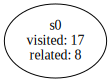

In [5]:
reload()
TOTAL = [x for _, x in load_work_map_all_years() if x.category == "snowball"]
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus", filter_function=filter_function))

state = strategy.initial
strategy.initial.visited

#strategy.initial.name
state


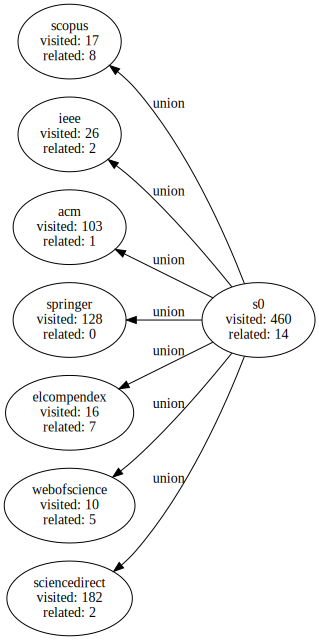

In [6]:
from snowballing.strategies import State

reload()
def busca_completa(libs, filter_function):
    union = None
    for dl in libs:
        strategy = Strategy(*busca(dl, filter_function=filter_function))
        strategy.initial.name = dl
        if union is None:
            union = strategy.initial.derive("union", name="s0")
        else:
            union.visited.update(strategy.initial.visited)
            union.related.update(strategy.initial.related)
            union.previous[0].append(strategy.initial)

    State.last_id = 0
    strategy.initial = union
    return strategy

strategy = busca_completa(["scopus", "ieee", "acm", "springer", "elcompendex", "webofscience", "sciencedirect"], filter_function)
#strategy.initial.find("acm")
strategy.initial

In [7]:
array = []

print ("--- Estratégia 1 (E1) ---")

name = "E1"
EP = len (state.related) / len (state.visited)
print ("Precision: " + "%.2f" %EP)

ER = len (state.related) / len (TOTAL)
print ("Recall: " + "%.2f" %ER)

FS = 2*((EP*ER)/(EP+ER))
print ("F-Measure: " + "%.2f" %FS)

array.append((name, EP, ER, FS))

--- Estratégia 1 (E1) ---
Precision: 0.47
Recall: 0.16
F-Measure: 0.24


## Estratégia 2 - Busca em todas Digital Libraries + Snowballing (Guideline - sfbu)

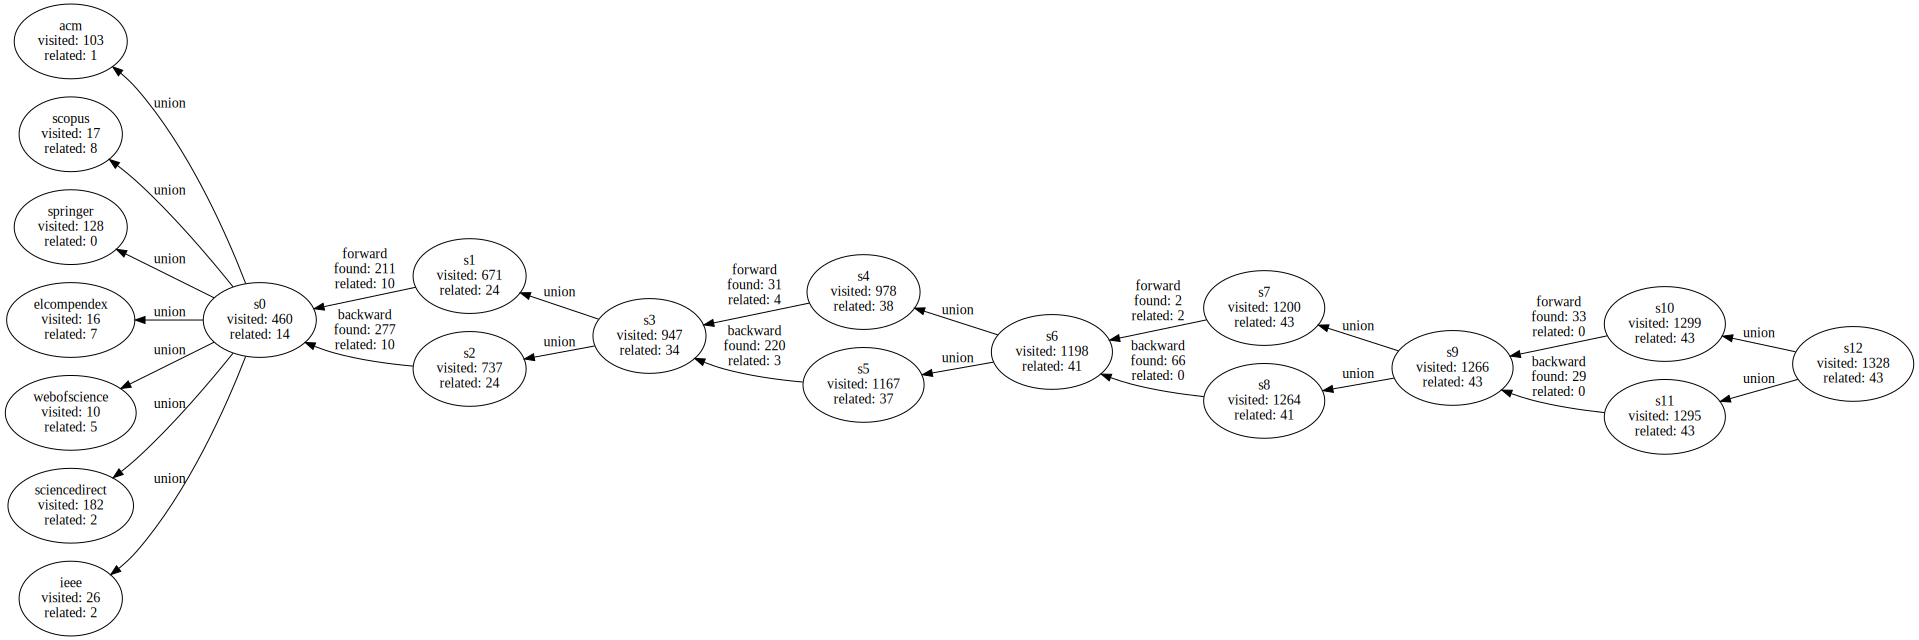

In [8]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = busca_completa(["acm", "scopus", "springer", "elcompendex", "webofscience", "sciencedirect", "ieee"], filter_function)
#Strategy(*busca("acm","scopus", filter_function=filter_function))

state = strategy.sfbu()
#state = strategy.bbff()
#state = strategy.ffbb()
#state = strategy.s2ffbb2u()

state

### Resumo 

#### Resumo da Busca em DL

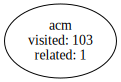

In [9]:
strategy.initial.find("acm")

In [10]:
# Visitados ACM
strategy.initial.find("acm").visited

{Three Integration Approaches for Map and B-SCP Requirements Engineering Techniques,
 Letter from the Editors,
 A Systemic Framework for the Field of Information Systems,
 HyperIntelligence: The Next Frontier,
 Rapid Design Labs: A Tool to Turbocharge Design-led Innovation,
 Model Transformations for Business-IT Alignment: From Collaborative Business Process to SoaML Service Model,
 HPC Needs a Tool Strategy,
 A Network Approach to Public Goods,
 Early Phase Requirements Assessment of a Teletreatment Trial,
 Closing the Gap: Automated Screening of Tax Returns to Identify Egregious Tax Shelters,
 Towards Classification of DNS Erroneous Queries,
 A Process Mining Approach to Linking the Study of Aptitude and Event Facets of Self-regulated Learning,
 Selfish Routing with Incomplete Information,
 Problem Frames and Business Strategy Modelling,
 Towards a Conceptual Framework and Tool Support for Linking Long-term Product and Business Planning with Agile Software Development,
 Using Roles a

In [11]:
# Relacionados ACM - encontrado no seed set
strategy.initial.find("webofscience").related

{Software process improvement: Supporting the linking of the software and the business strategies,
 Integration of strategic management, process improvement and quantitative measurement for managing the competitiveness of software engineering organizations,
 An approach to support the strategic alignment of software process improvement programs,
 Software engineering strategies: aligning software process improvement with strategic goals,
 ProPAMet: a Metric for process and project alignment}

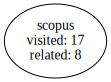

In [12]:
strategy.initial.find("scopus")

In [13]:
print("Visitados Scopus:")
strategy.initial.find("scopus").visited

Visitados Scopus:


{Application of GQM+ Strategies{	extregistered} in the Japanese space industry,
 SPI:I can't get no satisfaction-directing process improvement to meet business needs,
 A case study applying process and project alignment methodology,
 Critical success factors in software process improvement: A systematic review,
 An approach to support the strategic alignment of software process improvement programs,
 Demanding change: How to remain in business despite IT,
 A comparative study of SPI approaches with ProPAM,
 Software engineering strategies: aligning software process improvement with strategic goals,
 Software process improvement: Supporting the linking of the software and the business strategies,
 Using strategic planning for selection of SPI processes: An experience report,
 Integration of strategic management, process improvement and quantitative measurement for managing the competitiveness of software engineering organizations,
 A Low-overhead method for software process appraisal,

In [14]:
print("Relacionados Scopus - encontrado no seed set:")
strategy.initial.find("scopus").related

Relacionados Scopus - encontrado no seed set:


{Software process improvement: Supporting the linking of the software and the business strategies,
 Application of GQM+ Strategies{	extregistered} in the Japanese space industry,
 SPI:I can't get no satisfaction-directing process improvement to meet business needs,
 Integration of strategic management, process improvement and quantitative measurement for managing the competitiveness of software engineering organizations,
 A Low-overhead method for software process appraisal,
 An approach to support the strategic alignment of software process improvement programs,
 Software engineering strategies: aligning software process improvement with strategic goals,
 ProPAMet: a Metric for process and project alignment}

In [15]:
print("Artigo comum a ACM e Scopus:")
strategy.initial.find("acm").visited & strategy.initial.find("scopus").visited

Artigo comum a ACM e Scopus:


set()

#### Resumo do Snowballing

In [16]:
#Total de visitados = visitados no final - visitados no início
print ("Total visitados:")
len(state.visited - state.find("s0").visited)

Total visitados:


868

In [17]:
# Descrição dos Relacionados = relacionados no final - relacionados no início
print ("Total Relacionados: Lista dos que foram encontrados via Snowballing")
state.related - state.find("s0").related

Total Relacionados: Lista dos que foram encontrados via Snowballing


{Determining organization-specific process suitability,
 Bridging the gap between business strategy and software development,
 QFD Application in Software Process Management and Improvement Based on CMM,
 Blending CMM and Six Sigma to meet business goals,
 GQM+Strategies - Aligning business strategies with software measurement,
 Aligning Organizations Through Measurement,
 An elicitation instrument for operationalising GQM+ Strategies (GQM+ S-EI),
 Strategic alignment of software process improvement programs using QFD,
 Which Processes Are Needed in Five Years? Strategic Process Portfolio Management at the Japan Aerospace Exploration Agency (JAXA),
 Experiences and insights from applying gqm+ strategies in a systems product development organisation,
 The Rosetta stone methodology - A benefits driven approach to software process improvement,
 Aligning software projects with business objectives,
 Application of GQM+ Strategies in a small software development unit,
 Business Objectives as

In [18]:
print ("Encontrados via somente Snowballing:")
diff_related = state.related - state.find("s2").related
diff_related @ metakey_title

Encontrados via somente Snowballing:


['armbrust2010a - Determining organization-specific process suitability',
 'armbrust2010b - Which Processes Are Needed in Five Years? Strategic Process Portfolio Management at the Japan Aerospace Exploration Agency (JAXA)',
 'karlström2002a - Aggregating viewpoints for strategic software process improvement\x97a method and a case study',
 'münch2013c - Experiences and insights from applying gqm+ strategies in a systems product development organisation',
 'mcloughlin2010a - The Rosetta stone methodology - A benefits driven approach to software process improvement',
 'trendowicz2011a - Aligning software projects with business objectives',
 'wang2005a - Measuring and improving software process in China',
 'cocozza2014a - Application of GQM+ Strategies in a small software development unit',
 'trienekens2004a - Business Objectives as Drivers for Process Improvement: Practices and Experiences at Thales Naval the Netherlands (TNNL)',
 'birkhölzer2011a - A framework for systematic evaluation o

### Detalhamento por Estado / Aresta

#### Estado S0

#### Visitados

In [19]:
#S0 - Visitados
print("Visitados no Estado 0:")
state.find("s0").visited

Visitados no Estado 0:


{Three Integration Approaches for Map and B-SCP Requirements Engineering Techniques,
 Letter from the Editors,
 An advanced approach for modeling and detecting software vulnerabilities,
 Implementing requirements engineering processes throughout organizations: success factors and challenges,
 Software Engineering Knowledge Repositories,
 Subject index,
 Managing Reuse,
 Software measurement methods: recipes for success?,
 Calculating return on investment of training using process variation,
 Process differentiation and integration: The key to just-in-time in product development,
 Analysis of Risks in a Software Improvement Programme,
 Selfish Routing with Incomplete Information,
 Requirement process establishment and improvement from the viewpoint of cybernetics,
 Linking software development and business strategy through measurement,
 A maturity model for the Spanish software industry based on \ISO\ standards,
 A Survey of Service Identification Strategies,
 The Effect of Improving IT

#### Relacionados - Seed Set

In [20]:
#S0 - Relacionados - Encontrados via busca e que existem na lista dos Incluídos da SLR existente - são os seed set!
print("Relacionados no Estado 0: Seed Set")
state.find("s0").related @ metakey_title

Relacionados no Estado 0: Seed Set


['albuquerque2009a - Software process improvement: Supporting the linking of the software and the business strategies',
 'kaneko2011a - Application of GQM+ Strategies{\textregistered} in the Japanese space industry',
 "reiblein1997a - SPI:\x91I can't get no satisfaction\x92-directing process improvement to meet business needs",
 'sommerville1999a - Managing process inconsistency using viewpoints',
 'guzmán2010a - Integration of strategic management, process improvement and quantitative measurement for managing the competitiveness of software engineering organizations',
 'trienekens2005a - Business-oriented process improvement: practices and experiences at Thales Naval The Netherlands (TNNL)',
 'wilkie2007a - A Low-overhead method for software process appraisal',
 'mandić2010b - Utilizing GQM+ Strategies for business value analysis: An approach for evaluating business goals',
 'becker2008a - An approach to support the strategic alignment of software process improvement programs',
 'barr

#### Aresta s0 -> s2 (Backward - Iteração 1)

In [21]:
# S2 - Backward (Found) - Visitados na iteração 1
print("Backward - Qtd Referencias dos artigos visitados para chegar ao Estado 2, a partir do Estado 0:")
state.find("s2").delta_visited

Backward - Qtd Referencias dos artigos visitados para chegar ao Estado 2, a partir do Estado 0:


{Northern Ireland Software Industry Survey,
 Practical software measurement,
 Risk analysis of software process measurements,
 Cost Estimation with COCOMO II,
 Determining the impact of business strategies using principles from goal-oriented measurement,
 PROFES - A product driven process improvement methodology,
 Quality through Managed Improvement and Measurement (QMIM): Towards a Phased Development and Implementation of a Quality Management System for a Software Company,
 Linking software development and business strategy through measurement,
 Information Technology - Process Assessment - Part 5: An exemplar Process Assessment Model,
 Performance Results of CMMI-Based Process Improvement,
 GQM+Strategies - Aligning business strategies with software measurement,
 Root Cause Analysis and Gap Analysis - A Tale of Two Methods,
 A Framework for Formalizing Inconsistencies and Deviations in Human-Centered Systems,
 Viewpoints for Requirements Definition,
 Performance measurement andbusine

In [22]:
# S2 - Backward (Related) - Encontrados na iteração 1, via snowballing, que não foi encontrado via busca para o seed set.
print("Relacionados encontrados via Backward, para chegar ao Estado 2, a partir do Estado 0:")
state.find("s2").delta_related @ metakey_title

Relacionados encontrados via Backward, para chegar ao Estado 2, a partir do Estado 0:


['becker2008b - Strategic alignment of software process improvement programs using QFD',
 'liu2006a - Business-oriented software process improvement based on CMM using QFD',
 'basili2007a - Bridging the gap between business strategy and software development',
 'liu2005a - QFD Application in Software Process Management and Improvement Based on CMM',
 'basili2007b - GQM+Strategies - Aligning business strategies with software measurement',
 'kowalczyk2010a - Aligning software-related strategies in multi- organizational settings',
 'trienekens2009a - Entropy based software processes improvement',
 'debou2000a - Linking software process improvement to business strategies: Experiences from industry',
 'mccoy1998a - Interfacing three complementary technologies: Strategic planning, process modeling, and system dynamics',
 'martins2007b - ProPAM: SPI based on Process and Project Alignment']

#### Aresta s0 -> s1 (Forward - Iteração 1)

In [23]:
# S1 - Forward (Related) - Encontrados na iteração 1
print("Relacionados encontrados via Forward, para chegar ao Estado 1, a partir do Estado 0:")
state.find("s1").delta_related @ metakey_title

Relacionados encontrados via Forward, para chegar ao Estado 1, a partir do Estado 0:


['karlström2002a - Aggregating viewpoints for strategic software process improvement\x97a method and a case study',
 'münch2013c - Experiences and insights from applying gqm+ strategies in a systems product development organisation',
 'trendowicz2011a - Aligning software projects with business objectives',
 'cocozza2014a - Application of GQM+ Strategies in a small software development unit',
 'stallinger2013a - Development and Evaluation of Systems Engineering Strategies: An Assessment-Based Approach',
 'trendowicz2014a - Aligning Organizations Through Measurement',
 'unterkalmsteiner2014a - A conceptual framework for SPI evaluation',
 'mandić2010a - Utilizing GQM+ Strategies for an organization-wide earned value analysis',
 'mandić2010d - SAS: A tool for the GQM+strategies grid derivation process',
 'petersen2015a - An elicitation instrument for operationalising GQM+ Strategies (GQM+ S-EI)']

#### Relacionados - Encontrados Via Backward e Forward

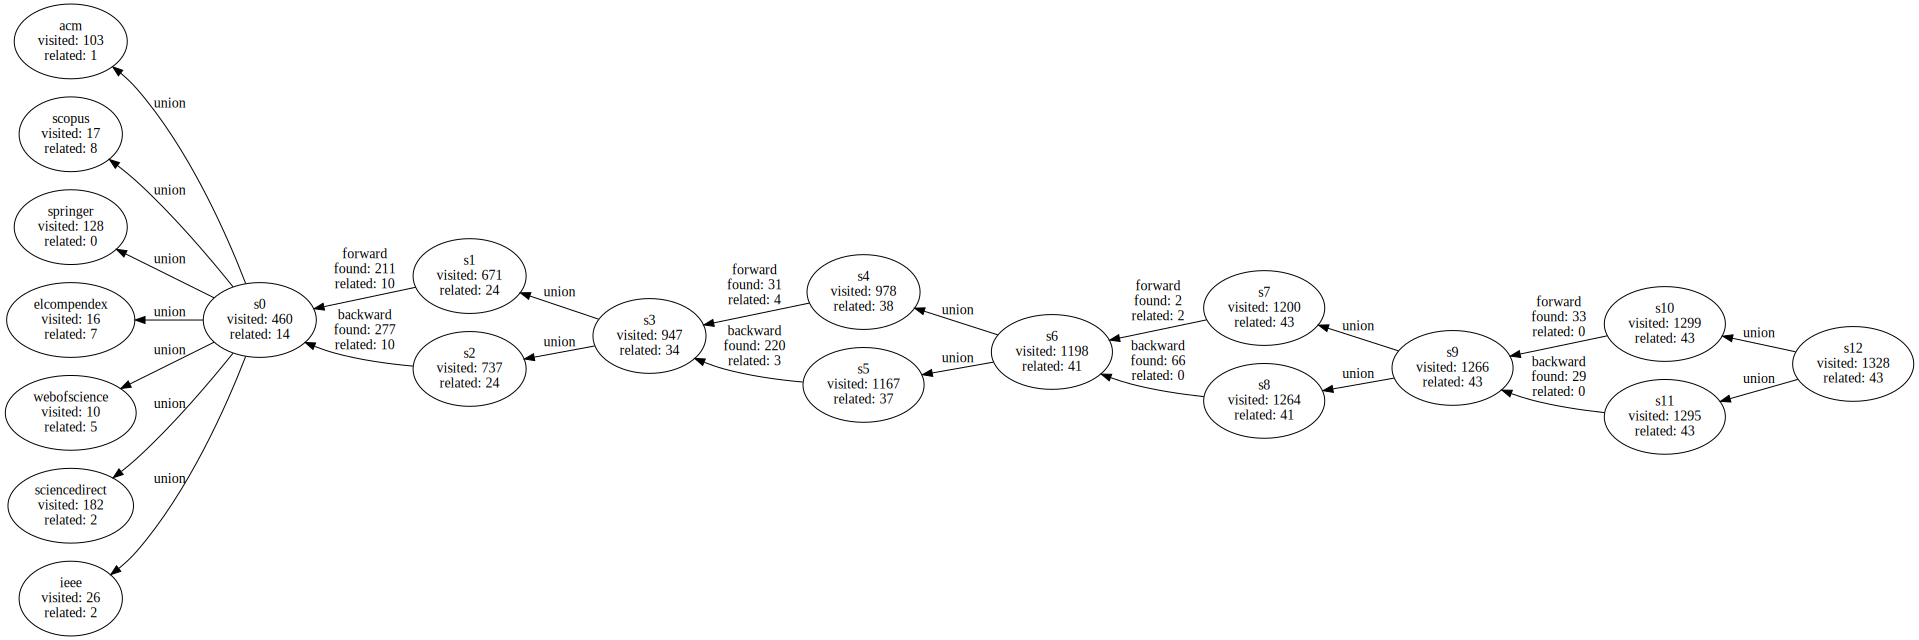

In [24]:
state

In [25]:
# Quantidade de artigo que existe em mais de uma biblioteca, após a união, no Estado S0, Ex, existe 1 artigo em acm e scopus.
state.find("s0").previous[0][1]

(len(strategy.initial.find("acm").visited) + len(strategy.initial.find("scopus").visited) + len(strategy.initial.find("elcompendex").visited) + len(strategy.initial.find("springer").visited) + len(strategy.initial.find("webofscience").visited) + len(strategy.initial.find("sciencedirect").visited)) - len(state.find("s0").visited)

-4

In [26]:
# Artigos encontrados via Backward e Forward - Foi incluído kitchenham 2007a como Snowball para o teste.
print ("Encontrados via Backward e Forward:")
separa_backward_forward(state) @ metakey_title

Encontrados via Backward e Forward:


[['basili2007a - Bridging the gap between business strategy and software development',
  'liu2005a - QFD Application in Software Process Management and Improvement Based on CMM',
  'murugappan2003a - Blending CMM and Six Sigma to meet business goals',
  'basili2007b - GQM+Strategies - Aligning business strategies with software measurement',
  'trienekens2009a - Entropy based software processes improvement',
  'basili2007c - GQM+ Strategies: A comprehensive methodology for aligning business strategies with software measurement',
  'mccoy1998a - Interfacing three complementary technologies: Strategic planning, process modeling, and system dynamics',
  'becker2008b - Strategic alignment of software process improvement programs using QFD',
  'liu2006a - Business-oriented software process improvement based on CMM using QFD',
  'kowalczyk2010a - Aligning software-related strategies in multi- organizational settings',
  'debou2000a - Linking software process improvement to business strategies

In [27]:
def duplicados(strategy, state):
    encontrados = set()
    result = set()
    soma = 0
    related = state.related - state.find("s0").related
    for work in state.related:
        inter = encontrados & (set(strategy.ref[work]) & related)
        if inter:
            soma += len(inter)
            encontrados |= inter
            print(work @ metakey, "backward", inter @ metakey)
        inter = encontrados & (set(strategy.rev_ref[work]) & related)
        if inter:
            soma += len(inter)
            encontrados |= inter
            print(work @ metakey, "forward", inter @ metakey)
    return soma

In [28]:
strategy.forward??

In [29]:
duplicados(strategy, state)

0

<IPython.core.display.Javascript object>


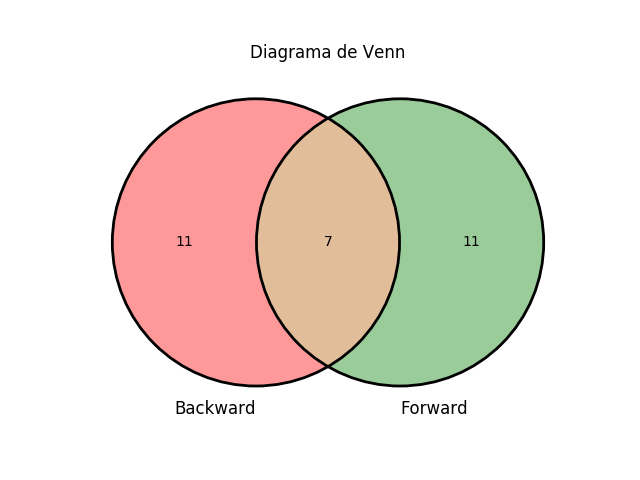

In [30]:
sets = separa_backward_forward(state)
sets = encontraria(strategy, state)
v = venn2(sets, set_labels = ('Backward', 'Forward'))
c = venn2_circles(sets)
plt.title('Diagrama de Venn')
plt.show()

In [32]:
#Backward - Execução de backward em sets[0]
print("Backward", sets[0] @ metakey)
print("Forward", sets[1] @ metakey)

Backward ['armbrust2010a', 'basili2007a', 'liu2005a', 'murugappan2003a', 'basili2007b', 'becker2008b', 'münch2013c', 'trendowicz2011a', 'kowalczyk2010a', 'mandić2010a', 'mandić2010d', 'debou2000a', 'martins2007b', 'trienekens2009a', 'basili2007c', 'mccoy1998a', 'liu2006a', 'münch2013a']
Forward ['armbrust2010a', 'trendowicz2014a', 'petersen2015a', 'becker2008b', 'armbrust2010b', 'münch2013c', 'mcloughlin2010a', 'trendowicz2011a', 'cocozza2014a', 'trienekens2004a', 'stallinger2013a', 'mandić2010a', 'kowalczyk2010a', 'mandić2010d', 'wang2005a', 'birkhölzer2011a', 'unterkalmsteiner2014a', 'karlström2002a']


In [33]:
state.find("s0").related @ metakey

['albuquerque2009a',
 'kaneko2011a',
 'reiblein1997a',
 'sommerville1999a',
 'guzmán2010a',
 'trienekens2005a',
 'wilkie2007a',
 'mandić2010b',
 'becker2008a',
 'barreto2010a',
 'basili2010a',
 'sun2010a',
 'plösch2011a',
 'martins2008a']

In [34]:
#x = v.get_patch_by_id('100')

In [35]:
#x.set_linestyle = "black"

In [36]:
#[x.metakey for x in state.find("s0").related]

#### Execução de Backward (Aresta S0 -> S2) em cada artigo relacionado do S0

In [37]:
print("Descreve o S0 -> S2:\n Execução de Backward em cada artigo do related \n")
descreve_delta(strategy, state, "s2")

Descreve o S0 -> S2:
 Execução de Backward em cada artigo do related 

backward albuquerque2009a
- softex2009a 
- salo2005b 
- dybå2003b 
- birk1998a 
- stalhane2004a 
- isoiec2004a 
- boehm2000b 
- reed2000a 
- kim1995a 
- mcnair1990a 
- martins2007b related
- prahalad1999a 
- komi2004a 
- cater2004a 
- wright2000a 
- cmusei2006a 
- bardin1977a 
- nollen2008a 
- kaplan2000a 
- isoiec2004b 
- adams1993a 
- thompson2000a 
- hefner2001a 
- caivano2005a 
- lawrence2001a 
- alloui2000a 
backward kaneko2011a
- becker1999a 
- jaxa2012a 
- basili2009a 
- basili1992a 
- ogc2002a 
- kaplan1992a 
- basili2007b related
- kowalczyk2010a related
- isaca2008a 
- kathuria2007a 
- isaca2005a 
backward reiblein1997a
- deming1986a 
- trade1992a 
- kaplan1993a 
- miller1995a 
- vlasveld1995a 
- iso1994b 
- iso1994a 
- kaplan1996b 
- group1997a 
- hinley1997a 
- humphrey1989a 
- itil1989a 
- isoies1997a 
- cmm1993a 
backward sommerville1999a
- emmet1996a 
- sommerville1995a 
- turgeon1996a 
- sommerville1

#### Execução de Forward em cada artigo relacionado do S1

In [38]:
print("Descreve o S0 -> S1:\n Execução de Forward em cada artigo do related \n")
descreve_delta(strategy, state, "s1")

Descreve o S0 -> S1:
 Execução de Forward em cada artigo do related 

forward albuquerque2009a
- lópez2012a 
- ardila2013b 
- ardila2013a 
forward kaneko2011a
- kobori2014a 
- trinkenreich2015a 
- heidrich2012b 
- razón2014b 
- asghari2012a 
- razón2014a 
- petersen2015a related
- teixeira2013a 
forward reiblein1997a
- stelzer1998b 
- halloran1999a 
- brouwer2007a 
- alshawi2007a 
- donkin2002a 
- schalken2007a 
- makipaa2004a 
- murakami2007a 
- baddoo2001a 
- bowers2001a 
forward sommerville1999a
- rayson2000a 
- katz2004b 
- michel2009a 
- lui2008a 
- alves2002a 
- vazquez2000a 
- nair2009a 
- türetken2007a 
- easterbrook2001a 
- berkovich2012a 
- ghose2007a 
- solaimani2012a 
- eljabiri2012a 
- bent2006a 
- marcus2005a 
- morisio2009a 
- karlström2002b 
- ghose2007b 
- nguyen2004a 
- gans2003a 
- karlström2005a 
- charrel2007a 
- aysolmaz2011a 
- acharya2005a 
- marcelloni2001a 
- müller2012a 
- taipale2007a 
- zhang2009a 
- zhiping2011a 
- kim2014a 
- zhang2010a 
- rayson1999a 
- 

#### Resumo do Precision e Recall

In [39]:
E2P = len (strategy.initial.related) / len (strategy.initial.visited)
#print (len (strategy.initial.related))
#print (len (strategy.initial.visited))
#print (E2P)
print ("Precision na Busca E2: %.2f%%" % E2P)

#print ("Precision no Snowballing - E2:")
#print(len(state.related - state.find("s0").related))
#print(len(state.visited - state.find("s0").visited))

E2PS = len(state.related - state.find("s0").related) / len(state.visited - state.find("s0").visited)

print ("\n""Precision no Snowballing E2: %.2f%%" % E2PS)

print("Precision no Snowballing E2 - Forward - 1 iteração: %.2f%%" % (len (state.find("s1").delta_related) / len (state.find("s1").delta_visited)))

print("Precision no Snowballing E2 - Backward - 1 iteração: %.2f%%" % (len (state.find("s2").delta_related) / len (state.find("s2").delta_visited)))

print("\n""Precision E2 (Busca + Snowballing): %.2f%%" % (len(state.related) / len(state.visited)))

#len (state.find("s1").related)

#len (state.find("s1").delta_related)
#len (state.find("s1").delta_visited)


name = "E2"
print ("Precision " + name)
EP = len (state.related) / len (state.visited)
print (EP)
print ("Recall " + name)
ER = len (state.related) / len (TOTAL)
print (ER)
print ("F-measure " + name)
FS = 2*((EP*ER)/(EP+ER))
print (FS)

array.append((name, EP, ER, FS))


Precision na Busca E2: 0.03%

Precision no Snowballing E2: 0.03%
Precision no Snowballing E2 - Forward - 1 iteração: 0.05%
Precision no Snowballing E2 - Backward - 1 iteração: 0.04%

Precision E2 (Busca + Snowballing): 0.03%
Precision E2
0.03237951807228916
Recall E2
0.8431372549019608
F-measure E2
0.062364031907179124


In [53]:
import statistics as s
s.harmonic_mean([])

StatisticsError: harmonic_mean requires at least one data point

In [46]:
import statistics as s
from collections import deque
def precision_recall(state, total, stop=""):
    # Precisao 0 quando nao visita nada
    array = [[
        "state", "precision", "recall", "fmeasure", "operation", 
        "related", "visited", "delta_related", "delta_visited",
        "accumulated_precision", "accumulated_recall", "accumulated_fmeasure"
    ]]
    stack = deque([state])
    visited = {id(state)}
    while stack:
        current = stack.pop()
        accumulated_recall = len(current.related) / len(total)
        recall = len(current.delta_related) / len(total)
        try:
            accumulated_precision = len(current.related) / len(current.visited)
            precision = len(current.delta_related) / len(current.delta_visited)
        except ZeroDivisionError:
            precision = float('nan')
        try:
            accumulated_fmeasure = s.harmonic_mean([accumulated_precision, accumulated_recall])
            fmeasure = s.harmonic_mean([precision, recall])
        except ZeroDivisionError:
            fmeasure = float('nan')
            
            
        array.append([
            current.name,
            precision,
            recall,
            fmeasure,
            current.previous[1] if current.previous else "-",
            len(current.related),
            len(current.visited),
            len(current.delta_related),
            len(current.delta_visited),
            accumulated_precision,
            accumulated_recall,
            accumulated_fmeasure,
        ])
        if current.name == stop:
            break
        if current.previous:              
            antecessors = current.previous[0]
            for previous in antecessors:
                if id(previous) not in visited:
                    visited.add(id(previous))
                    stack.appendleft(previous)
    return array

In [47]:
df = pd.DataFrame(list(reversed(precision_recall(state, TOTAL))))
df.columns = df.iloc[-1]
df = df.drop(df.index[-1])
df

20,state,precision,recall,fmeasure,operation,related,visited,delta_related,delta_visited,accumulated_precision,accumulated_recall,accumulated_fmeasure
0,ieee,0.0769231,0.0392157,0.0519481,-,2,26,2,26,0.0769231,0.0392157,0.0519481
1,sciencedirect,0.010989,0.0392157,0.0171674,-,2,182,2,182,0.010989,0.0392157,0.0171674
2,webofscience,0.5,0.0980392,0.163934,-,5,10,5,10,0.5,0.0980392,0.163934
3,elcompendex,0.4375,0.137255,0.208955,-,7,16,7,16,0.4375,0.137255,0.208955
4,springer,0,0,0,-,0,128,0,128,0,0,0
5,scopus,0.470588,0.156863,0.235294,-,8,17,8,17,0.470588,0.156863,0.235294
6,acm,0.00970874,0.0196078,0.012987,-,1,103,1,103,0.00970874,0.0196078,0.012987
7,s0,NaN,0,0,union,14,460,0,0,0.0304348,0.27451,0.0547945
8,s2,0.0361011,0.196078,0.0609756,backward,24,737,10,277,0.0325645,0.470588,0.0609137
9,s1,0.0473934,0.196078,0.0763359,forward,24,671,10,211,0.0357675,0.470588,0.066482


In [60]:
df["state"]  + "\n" + df["operation"]

0              ieee\n-
1     sciencedirect\n-
2      webofscience\n-
3       elcompendex\n-
4          springer\n-
5            scopus\n-
6               acm\n-
7            s0\nunion
8         s2\nbackward
9          s1\nforward
10           s3\nunion
11        s5\nbackward
12         s4\nforward
13           s6\nunion
14        s8\nbackward
15         s7\nforward
16           s9\nunion
17       s11\nbackward
18        s10\nforward
19          s12\nunion
dtype: object

<IPython.core.display.Javascript object>


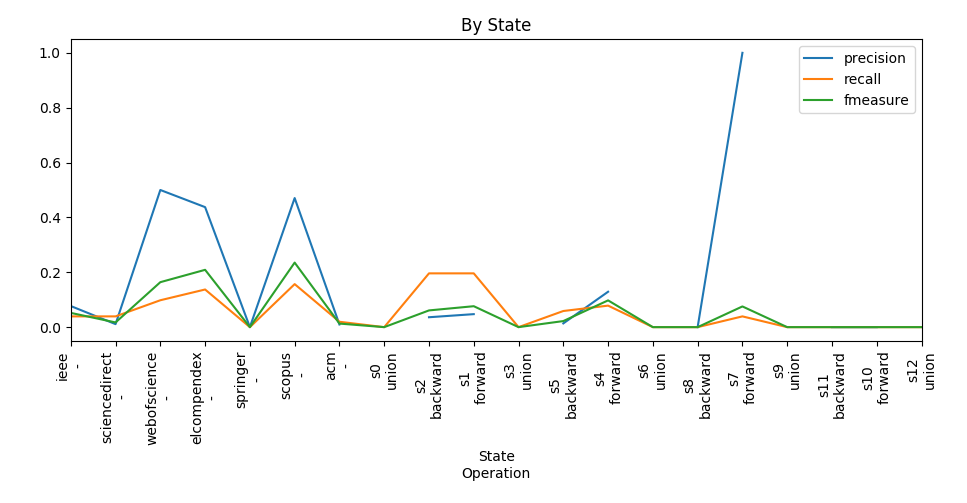

In [76]:
fig = plt.figure()
df['precision'].plot(legend=True)
df['recall'].plot(legend=True)
df['fmeasure'].plot(legend=True)
ax = plt.gca()
ax.set_xticklabels(df["state"] + "\n" + df["operation"])
ax.set_title("By State");
plt.xticks(np.arange(0, len(df), 1.0), rotation='vertical')
plt.xlabel("State\nOperation")
plt.tight_layout()

20

<IPython.core.display.Javascript object>


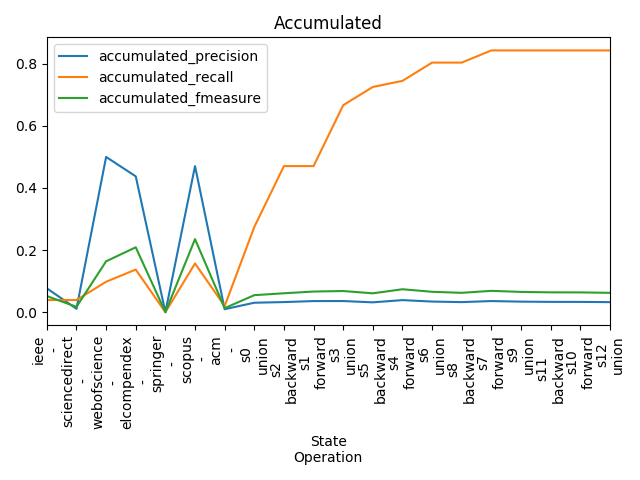

In [75]:
fig = plt.figure()
df['accumulated_precision'].plot(legend=True)
df['accumulated_recall'].plot(legend=True)
df['accumulated_fmeasure'].plot(legend=True)
ax = plt.gca()
ax.set_xticklabels(df["state"] + "\n" + df["operation"])
plt.xticks(np.arange(0, len(df), 1.0), rotation='vertical')
plt.xlabel("State\nOperation")
ax.set_title("Accumulated");
plt.tight_layout()

## Estratégia 3 - Busca Informal (Google Scholar) + Snowballing (Guideline - sfbu)

In [ ]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("gs", filter_function=filter_function))
state = strategy.sfbu()
state

In [ ]:
name = "E3"
print ("Precision " + name)
EP = len (state.related) / len (state.visited)
print (EP)
print ("Recall " + name)
ER = len (state.related) / len (TOTAL)
print (ER)

print ("F-measure " + name)
FS = 2*((EP*ER)/(EP+ER))
print (FS)

array.append((name, EP, ER, FS))


## Estratégia 4 - Busca em Scopus + Snowballing (Guideline - sfbu)

In [ ]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus", filter_function=filter_function))

#from copy import copy
#strategy.initial.visited = copy(strategy.initial.related)
state = strategy.sfbu()
state

In [ ]:
descreve_delta(strategy, state, "s2")


In [ ]:
texto = """backward becker2008a
- weber2005a 
- hierholzer1998a 
- debou1999a 
- liu2005a 
- yamamura1999a 
- cox1992a 
- grady1997a 
- biró1999a 
- mccoy1998a 
- dyba2005a 
- humphrey1989b 
- paulk1993a 
- chrissis2003a 
- zaijun2005a 
- peterson1995a 
- brodman1995a 
- akao1990a 
- pitterman2000a 
- pulford1996a 
- montoni2007a 
- yin2003a 
- isoiec2003a 
- zahran1998a 
- niazi2003a 
backward martins2008a
- arthur1993a 
- isoiec1998a 
- salo2005a 
- krasner1997a 
- kuvaja1994a 
- cmm2002a 
- isoiec1998c 
- isoiec1998b 
- emam1999a 
- pfleeger1994a 
- solingen1999a 
- paulk1993a 
- vertage1994a 
- martins2007b 
backward reiblein1997a
- kaplan1993a 
- miller1995a 
- trade1992a 
- hinley1997a 
- vlasveld1995a 
- deming1986a 
- group1997a 
- iso1994b 
- itil1989a 
- iso1994a 
- cmm1993a 
- humphrey1989a 
- isoies1997a 
- kaplan1996b 
backward albuquerque2009a
- birk2002a 
- stalhane2004a 
- prahalad1999a 
- softex2009a 
- boehm2000b 
- cmusei2006a 
- nollen2008a 
- salo2005b 
- wright2000a 
- isoiec2004a 
- lawrence2001a 
- reed2000a 
- cater2004a 
- dybå2003b 
- birk1998a 
- bardin1977a 
- hefner2001a 
- thompson2000a 
- kim1995a 
- isoiec2004b 
- alloui2000a 
- caivano2005a 
- mcnair1990a 
- kaplan2000a 
- adams1993a 
- komi2004a 
- martins2007b 
backward kaneko2011a
- kathuria2007a 
- isaca2005a 
- kaplan1992a 
- basili2009a 
- basili2007b 
- becker1999a 
- isaca2008a 
- ogc2002a 
- basili1992a 
- jaxa2012a 
- kowalczyk2010a 
backward guzmán2010a
- ebert2007a 
- mcgarry2002a 
- goethert2004a 
- kaplan2008a 
- chastek2009a 
- tuan2006a 
- basili2009b 
- el2007a 
- sei2006b 
- kojima2008a 
- mishra2008a 
- long2008a 
- watson2007a 
- kanji2007a 
- oliveira2009a 
- porter1979a 
- lamb1984a 
- isoiec2007a 
- asgarkhani2006a 
- harjumaa2008a 
- mcloone2007a 
- mehra2004a 
- kamel2009a 
- card2003a 
- neergaard2007a 
- basili2010a related
- kaplan2005a 
- gopal2005a 
- peng2007a 
- kahraman2007a 
- isoiec2004a 
- fahey2007a 
- kaplan2006a 
- trienekens2009a related
- dyba2005a 
- shull2006a 
- el2001a 
- qi2007a 
- issac2006a 
- isoiec2008a 
- kaplan1997a 
- kuppusamy2008a 
- capell2004a 
- goethert2003a 
backward wilkie2007a
- iso2006a 
- anacleto2004b 
- wilkie2005a 
- mcfeeley1996a 
- anacleto2004a 
- makinen2000a 
- caffery2004a 
- sei2004a 
- wilkie2004a 
- cspt2003a 
- institute2005a 
- chrissis2003a 
- ISOIEC2006a 
- caffery2005a 
- mcfall2003a 
- sei2005a 
- paulk1995a 
- cignoni1999a 
- team2007a 
- rout2001a 
backward plösch2011a
- shewhart1931a 
- isoiec2003b 
- simon2002a 
- venzin2003a 
- cmmi2006a 
- mcfeeley1996a 
- isoiec1998d 
- dion1993a"""

In [ ]:
conjuntos = [set(x.split("-")[1:]) for x in texto.split("backward")[1:]]

In [ ]:
conjuntos[0] & conjuntos[1]

In [ ]:
name = "E4"
print ("Precision " + name)
EP = len (state.related) / len (state.visited)
print (EP)
print ("Recall " + name)
ER = len (state.related) / len (TOTAL)
print (ER)

print ("F-measure " + name)
FS = 2*((EP*ER)/(EP+ER))
print (FS)

array.append((name, EP, ER, FS))

In [ ]:
state.find("s0").related

In [ ]:
state.find("s2").related

In [ ]:
state.find("s0").visited

In [ ]:
# Com backward de mendes2004a é possível encontrar 2 (resultado da celula)
state.related & set(strategy.ref[work_by_varname("mendes2004a")])

In [ ]:
# Com backward de ... em S2, encontrou 1 (resultado da celula)
state.find("s2").delta_related & set(strategy.ref[work_by_varname("mendes2004a")])

In [ ]:
# Com forward de ... em S1, encontrou 1 (resultado da celula)
state.find("s1").delta_related & set(strategy.rev_ref[work_by_varname("mendes2004a")])

In [ ]:
len(state.find("s1").delta_visited)

In [ ]:
#len(state.find("s1").delta_visited & set(strategy.rev_ref[work_by_varname("mendes2004a")]))
# forward
len(set(strategy.rev_ref[work_by_varname("mendes2004a")]))

In [ ]:
# backward
len(set(strategy.ref[work_by_varname("mendes2004a")]))

In [ ]:
search_state = strategy.initial
search_state.related

## Estratégia 5 - Busca em Scopus + Snowballing (Short Paper - s2ffbb2u)

In [ ]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus", filter_function=filter_function))
state = strategy.s2bbff2u()
state

In [ ]:
name = "E5"
print ("Precision " + name)
EP = len (state.related) / len (state.visited)
print (EP)
print ("Recall " + name)
ER = len (state.related) / len (TOTAL)
print (ER)

print ("F-measure " + name)
FS = 2*((EP*ER)/(EP+ER))
print (FS)

array.append((name, EP, ER, FS))

In [ ]:
state.find("s0").related 

In [ ]:
state.find("s1").related 

In [ ]:
state.find("s3").related 

In [ ]:
sx, sy = state.previous[0]

sx.related & sy.related


In [ ]:
sx.name

In [ ]:
sy.name

In [ ]:
# Artigos encontrados via Backward e Forward - Foi incluído kitchenham 2007a como Snowball para o teste.
print ("Encontrados via Backward e Forward:")
separa_backward_forward(state) @ metakey_title

In [ ]:
# S1 - Forward (Related) - Encontrados na iteração 1
print("Relacionados encontrados via Forward, para chegar ao Estado 1, a partir do Estado 0:")
state.find("s1").delta_related @ metakey_title

## Estratégia 6 - Busca em Scopus + Snowballing (JF - bbff)

In [ ]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus", filter_function=filter_function))
state = strategy.bbff()
state

In [ ]:
strategy._repeat??

In [ ]:
name = "E6"
print ("Precision " + name)
EP = len (state.related) / len (state.visited)
print (EP)
print ("Recall " + name)
ER = len (state.related) / len (TOTAL)
print (ER)

print ("F-measure " + name)
FS = 2*((EP*ER)/(EP+ER))
print (FS)

array.append((name, EP, ER, FS))

## Estratégia 7 - Busca em Scopus + Snowballing (JF - ffbb)

In [ ]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus", filter_function=filter_function))
state = strategy.ffbb()
state

In [ ]:
name = "E7"
print ("Precision " + name)
EP = len (state.related) / len (state.visited)
print (EP)
print ("Recall " + name)
ER = len (state.related) / len (TOTAL)
print (ER)

print ("F-measure " + name)
FS = 2*((EP*ER)/(EP+ER))
print (FS)

array.append((name, EP, ER, FS))

# Análise das Estratégias

In [ ]:
%matplotlib notebook
import pandas as pd

In [ ]:
df = pd.DataFrame (array,columns = ['Estratégia','Precision','Recall','F-Measure'])
df.index = df['Estratégia']
df

In [ ]:
import matplotlib.pyplot as plt
ax = df.plot.bar(title ="Precision e Recall das Estratégias")
plt.tight_layout()


In [ ]:
df

In [ ]:
#df.to_csv("estrategias.csv")
df.to_excel("estrategias.xlsx")

# Individual

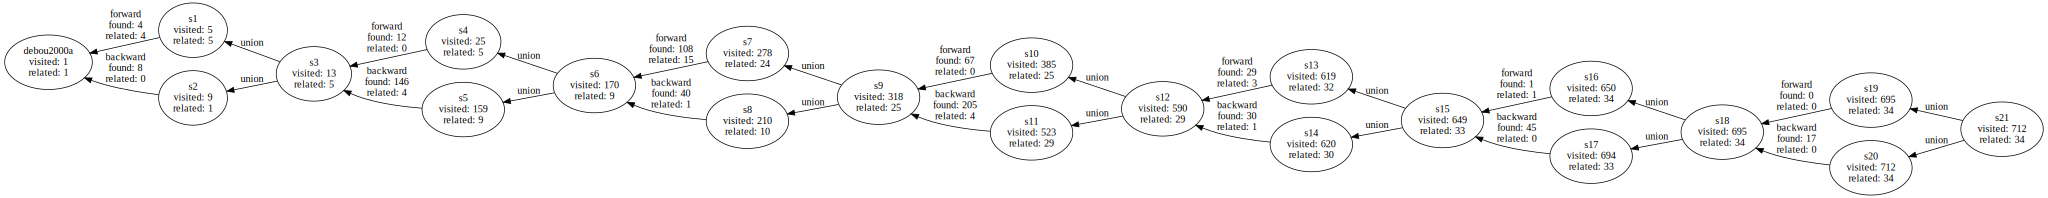

In [80]:
reload()
#NAME = "guzmán2010a"
NAME = "debou2000a"
filter_function = lambda x: x.category in ("snowball", "forward", "backward")
seedset = {work_by_varname(NAME)}
strategy = Strategy(seedset, filter_function)
strategy.initial.name = NAME
state = strategy.sfbu()
state

In [ ]:
state.find("s2").delta_visited @ metakey_title

In [ ]:
strategy.bfbf()